In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import transform_helper

sph = transform_helper.StockReturn_Pooling_Helper()

# Create plots for Fundamental Assumption
ssm = transform_helper.StockPrice_shiftedMean_Helper()
ss_df = ssm.gen_prices(.001, .02, [10, 20], num_returns=252)
fig_data, axs_data = ssm.plot_data(ss_df, visible=False)
fig_segs, axs_segs = ssm.plot_segments(ss_df, visible=False)

# Create plots for shifted price
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig_sp, ax_sp = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax_sp)

plt.close(fig_sp)

# Create plots for relative price
rph = transform_helper.RelativePrice_Helper()
series = rph.gen_data(attrs=["area", "price"])

labels=[ "USD", "USD", "RMB", "HKD" ]

fig_rp, ax_rp = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series, ax=ax_rp, labels=labels, xlabel="Area", ylabel="Price (local)")

plt.close(fig_rp)

In [4]:
# Geron Housing Data example
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# Data science in practice

Being a successful Data Scientist is much more than just knowing models.

Being able to gather, join, and clean Data is a prerequisite to being able to train a model.
- the remarkable success of Large Langauge Models (e.g., ChatGPT) is in large part due to vast quantities of carefully curated data

*Manipulating and transforming* the Data into a form in which a successful model can be built
is a skill that may not be truly appreciated.
- data is frequently transformed from its raw form to synthesized features and targets
- the relationship between features and target may not be present in raw form

It is this latter skill that we know focus on.

Recall the Fundamental Assumption of Machine Learning

- That each training and test example $(\x, \y)$ 
- is a sample drawn from $\pdata$
- where $\pdata$ is the true (but unknown) distribution of examples


It is surprisingly easy to violate this assumption

Consider the timeseries of prices of an equity

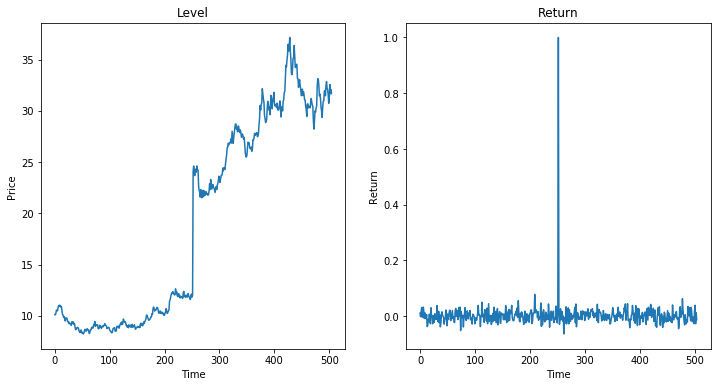

In [7]:
fig_data

One can easily see that there are two distributions here
- a low-mean (and low variance) distribution prior to the jump in Price
- a high-mean (and high variance) distribution after the jump

The test data (drawn post jump) is **not** from the same distribution as the training data (pre-jump).

In fact: if the training data also includes examples post-jump
- it would seem that the training data comes from the union of *two different* distributions

At first glance, this seems surprising.

After all, each Price is drawn from the distribution of a single equity.

But, as is very typical in Finance, our distributions *vary with time*.

So, in order to satisfy the Assumption
- we typically transform the Price distribution into a Return distribution
- which is often (but not always) more stable over time

This also has the benefit of making sure that the training examples all come from a single distribution.
- The more homogeneous the distribution
- The more statistical support there is for the model

# Non-homogeneous data: examples

We will imagine that the available data comes from one or more *groups* each with its own distribution.

One typical reason for more than one group is time-varying data.

Consider the following graph illustrating the joint distribution of Price (target) and Size (features)


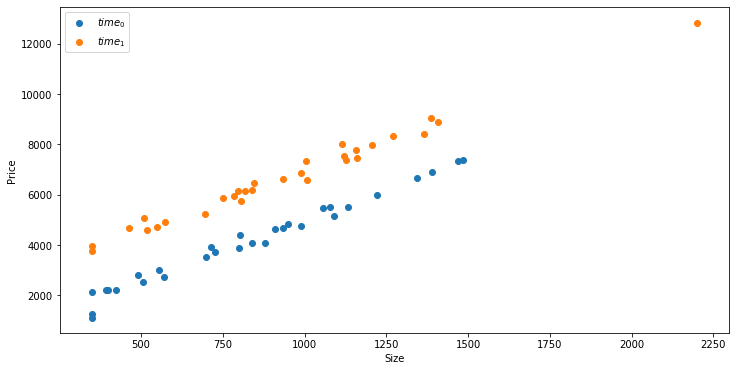

In [8]:
fig_sp

It appears that the data in different groups is similar, but not identical.

Once we make that observation
- we might be tempted to fit a *separate model* for each group.  This is not a great idea
- Which model do we use for an out of sample example ?
- The "goodness of fit" increases with sample size

But: how do we even **discover** the presence of two groups (I added the colors for illustration) ?

There are multiple opportunities for a Data Scientist following the Recipe to uncover this
- Exploratory data analysis
    - slicing the data reveals different distributions
- Error Analysis
    - fitting a single line to all examples: the sign of the errors differs by group
    


Another cause for more than one group is differences in market/geography.

Consider the plot

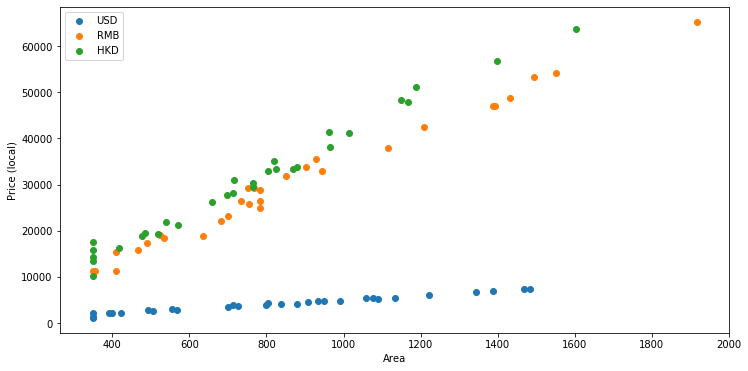

In [9]:
fig_rp

Even though each group seems different **on the surface**
- there may be a *single* relationship between targets and features
- that is the *same* across groups
- at a **deeper** level

Being able to transform data to uncover the deeper level relationship between targets and features
- is a skill **critical to being able to construct good models**

## Why do we have to deal with non-homogeneous data ?

- The examples may be presented as a mixture
    - first example: long window on time-series data
- You often need to **pool** groups in order to enlarge the number of examples for training
    - second example: we intentionally pooled data across geographies
    - more examples facilitate better models
    - and more parameters
    

For example, a lot of Financial data is sampled at low frequency (e.g., daily)
- So not a lot of data points for a single ticker in a short time period
- Pool over time to increase number of examples
    - groups caused by time-varying distribution of single stock price/return
- Pool over many similar tickers to increase number of examples
    - distribution per ticker is different

**Example: equity trading volume**
   
It might be reasonable to hypothesize that
- the daily trading volume (or changes in volume) of an equity is a useful feature
- for predicting stock behavior
- stocks with high volume *appear* to be more liquid
- jumps in volume may be a signal


But measuring volume in units of "number of shares" may expose us to non-homogeneity.

Suppose our examples are observations of a *single equity* on different dates
- volume of the equity may be related to the total market volume
    - not a signal related to just this equity: total market volume spikes on economic news
    - Normalize to remove variation due to *time*
        -  change units to shares as fraction of total daily volume

Suppose our examples include *different* equities (observed on the same dates)
- $\text{MarketCap} = \text{no. of shares outstanding} * \text{Price/share}$
- Another equity with identical$\text{MarketCap}$
    - Double the shares  $\rightarrow$ reduce $\text{Price/share}$ by $50 \%$
    - stock split of same stock yields same phenomenon
    - the *number* of shares is not informative
- Normalize to remove variation *across* tickers
    - $\text{Dollar volume} = \text{no. of shares traded} * \text{Price/share}$

**Example: modeling prepayments**

Consider the following example.

Suppose our goal is to predict whether a borrow will prepay a mortgage.  

As raw features: we have variables
- Borrower's interest rate $C$
- Rate $r$ at a which a mortgage could be re-financed

The borrower has an incentive to prepay if $C > r$.

What training examples should we use ?

Remember: we want the test examples (observed in the near future) to be similar to the training examples.

Should our examples only include instances where $r \approx r'$
- where $r'$ is today's re-finance rate

We may not have a lot of *historical* data with a contemporaneous re-finance rate close to $r'$.

Consider a different approach to modeling:
- we use a *synthetic* feature $I$  capturing incentive to prepay
- rather than just raw values $C, r$ for borrower's current rate and contemporaneous re-finance rate

For example, we could create feature $I$ in several possible ways
- $I = \max{}(0, C-r)$
- $I = \max{}(0, \frac{C}{r} -1)$



Using the synthetic feature opens up the possibility of using a lot more historical data
- Many more historical episodes with a particular value of $\frac{C}{r}$ or $C-r$
- Than examples where the then-current re-finance rate equals today's rate $r$

In essence
- we have pooled data over time
- each time period defines a different group (similar values of $r$)
- different groups have different distributions
- that we *have made uniform* by using $I$ rather than $C$ and $r$ as features
    - discovered the **true** relationship (based on incentive)
    - rather than the *surface* relationship (based on levels)

# Becoming a successful Data Scientist

The examples in this notebook illustrate the challenges that a Data Scientist encounters.

What distinguishes an "good" Data Scientist from a "great" one is the knowledge and skill to
recognize and circumvent the challenges.

**A key skill of a Data Scientist** is the ability
- to strip away surface differences and reveal underlying commonality between groups
- being able to adapt models to deal with multiple groups

You can *recognize* the challenge
- before starting: by superior Exploratory Data Analysis
- after staring: by superior Error Analysis

One you recognize the challenges, you may be able to *circumvent* them by
- Transforming the data
    - imposing homogeneity
    - adding features that distinguish between groups
- Find the correct functional form for the model
    - linear
    - polynomial
    - something new

## The world before Black Scholes option pricing

The relationships between targets and features we have explored have usually been simple.

In the real world: the relationships are complex
- missing features
- interaction between features
- described by a new "theory" that is validated by data


Consider the goal of predicting the price of a call option from features of the option.

In the days before the Black Scholes pricing formula was discovered
- people proposed (partially successful) functional forms relating price to features
    - traders carried around tables of approximate prices
    - based on models that partially/conditionally explained prices

Even without a perfect model, an imaginative Data Scientist can come up with partially successful models
with high utility.

A Data Scientist needs
- intuition
- imagination
- scientific rigor and the will to experiment

in order to be able to postulate/test theories relating target to features.

A couple of observations on the Black Scholes call price formula

$$
C = \mathcal{N}(d_1) S_t + - \mathcal{N}(d_2)K * e^{- r*t }
$$
where
$$
\begin{array} \\
d_1 & = & \frac{ \log_e (\frac{S_t}{K}) + (r + .5*\sigma^2)*t
               }
               {
               \sigma * \sqrt{t}
               } 
               \\
d_2 & = & d_1 - \sigma * \sqrt{t}
\end{array}
$$

Notice some interesting "transformed features" in the $d_1$ term
- Price is relative to the strike : $\frac{S_t}{K}$
- Volatility is scaled by time to maturity $t$: $\sigma * \sqrt{t}$

These non-obvious features derive, perhaps, from a need to "normalize" the feature.

# Wrap-up

Obviously, these examples were contrived and overly simple.

In practice, more complex transformations are necessary to make groups more homogeneous.

The insight of the Data Scientist is key in guiding the process.

We will show transformations that address each of these examples (and more) in a separate module.

In [10]:
print("Done")

Done
